In [14]:
# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
EPOCHS = 2

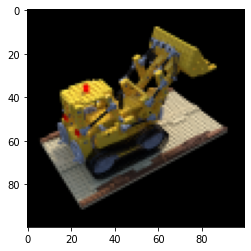

In [15]:
file_name = "tiny_nerf_data.npz"
url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, FOCAL) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

Camera poses taken for the considering object for illustration purposes.

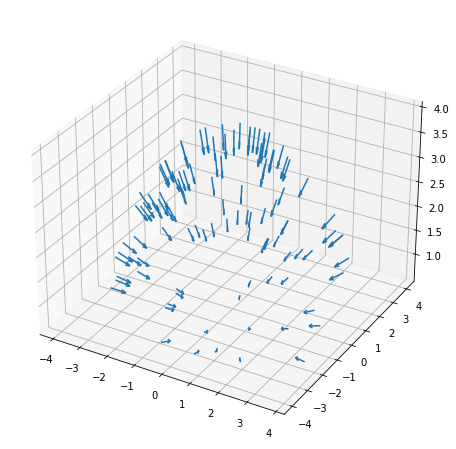

In [16]:
outward_vec = np.array([0,0,-1]).reshape((3, 1))

dir_matrices = []
origin_coords = []

for data in poses:
    transform_matix = data
    r_mat = transform_matix[:3, :3]

    dir_vec = np.dot(r_mat, outward_vec) 
    dir_matrices.append(dir_vec)

    o_vec = transform_matix[:3, -1:]
    origin_coords.append(o_vec)


dir_matrices = np.array(dir_matrices)
origin_coords = np.array(origin_coords)

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')

_ = ax.quiver(origin_coords[:, 0],
              origin_coords[:, 1],
              origin_coords[:, 2],
              dir_matrices[:, 0],
              dir_matrices[:, 1],
              dir_matrices[:, 2], length=0.5, normalize=True)
plt.show()

In [17]:
def encode_ray_position(x, encode_dims = 16):
    positions = [x]
    for i in range(encode_dims):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)

In [18]:
def get_rays(height, width, focal_length, pose):
   
    # Build a meshgrid for the rays.
    x, y = tf.meshgrid(
                tf.range(width, dtype=tf.float32),
                tf.range(height, dtype=tf.float32),
                indexing="xy",
            )

    # Normalize the x axis coordinates.
    transformed_x = (x - width * 0.5) / focal_length

    # Normalize the y axis coordinates.
    transformed_y = (y - height * 0.5) / focal_length

    # Create the direction unit vectors.
    directions = tf.stack([transformed_x, -transformed_y, -tf.ones_like(x)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)

In [19]:
def render_encoded_rays(ray_origins, ray_directions, near, far, rand=False):

    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, NUM_SAMPLES)
    
    if rand:
        # Add uniform noise into sample space to make the sampling continuous.
        shape = list(ray_origins.shape[:-1]) + [NUM_SAMPLES]
        noise = tf.random.uniform(shape=shape) * (far - near) / NUM_SAMPLES
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )

    rays_transformed = tf.reshape(rays, [-1, 3])
    rays_transformed = encode_ray_position(rays_transformed)
    return (rays_transformed, t_vals)

In [28]:
def generate_rays_per_image(pose):

    (ray_origins, ray_directions) = get_rays(H, W, focal_length=FOCAL, pose=pose)

    (rays_encoded, t_vals) = render_encoded_rays(
                                    ray_origins=ray_origins,
                                    ray_directions=ray_directions,
                                    near=2.0,
                                    far=6.0,
                                    rand=True,
                                )

    return (rays_encoded, t_vals)

### Dataset preparation (Copied from the keras documentation for simplicity)

In [29]:
# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training ray dataset.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)

train_ray_ds = train_pose_ds.map(generate_rays_per_image, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
        training_ds.shuffle(BATCH_SIZE)
        .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
        .prefetch(AUTO)
    )

# Make the validation ray dataset.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)

val_ray_ds = val_pose_ds.map(generate_rays_per_image, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
        validation_ds.shuffle(BATCH_SIZE)
        .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
        .prefetch(AUTO)
    )

### Build the NeRF Model

In [27]:
def get_nerf_model(num_layers, num_pos, position_encode_dim_size=16):

    inputs = keras.Input(shape=(num_pos, 2 * 3 * position_encode_dim_size + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)

        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)

    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_image(model, rays_flat, t_vals, rand=True, train=True):
  
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4)) # 4 because RGB and density value

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals. # delta shape = (num_samples)
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

### Model Training Implementation

In [30]:
class NeRF(keras.Model):
    '''
    Using this type implementation because it is easier to fit the model and do other tasks using keras inbuild functionalities.
    '''

    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_image(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_image(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_image(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.preprocessing.image.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.preprocessing.image.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()